# visualization of training and testinng

## visualization of training process

In [1]:
import argparse
import pickle
import random
import numpy as np
import torch

device = 'cuda:0'

checkpoint_dir = './checkpoints/checkpoints_jinan_bv1h'
#load argparse from pkl
with open(checkpoint_dir + '/args.pkl', 'rb') as f:
    args = pickle.load(f)

for arg in vars(args):
    print(f"{arg:<30}: {getattr(args, arg)}")

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/checkpoints_jinan_bv1h/args.pkl'

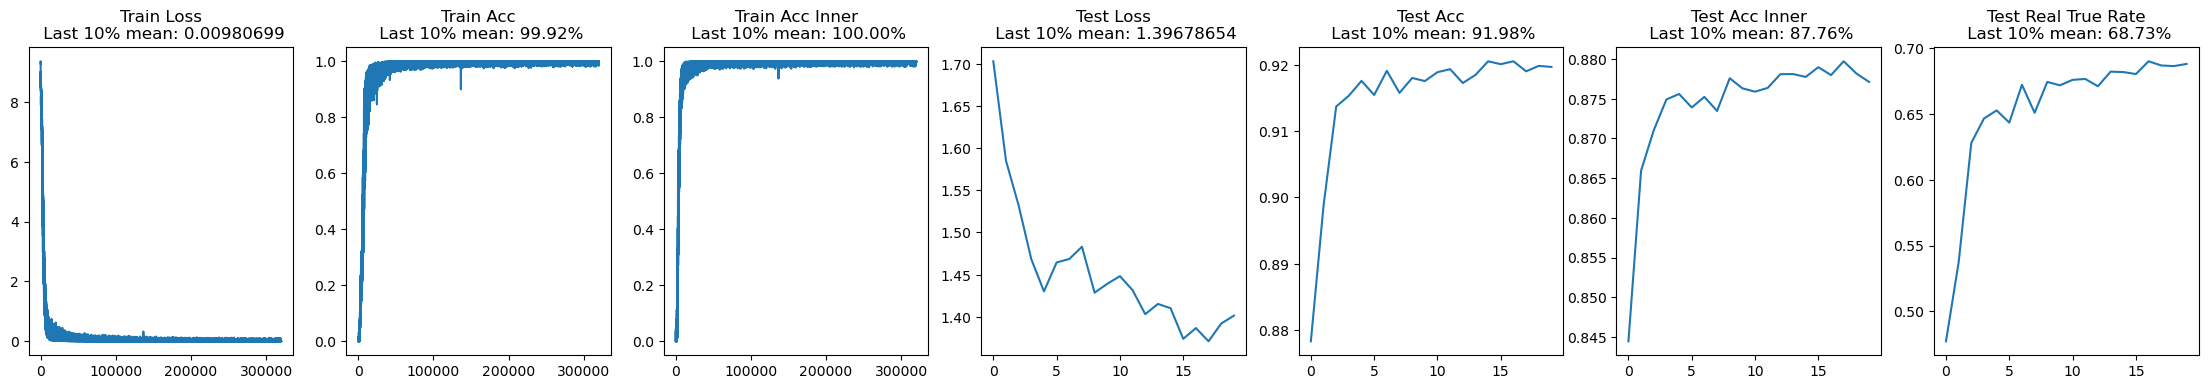

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

log_dir = checkpoint_dir

# load the logger
with open(log_dir + '/logger_train_loss.pkl', 'rb') as f:
    logger_train_loss = pickle.load(f)
with open(log_dir + '/logger_train_acc.pkl', 'rb') as f:
    logger_train_acc = pickle.load(f)
with open(log_dir + '/logger_train_acc_inner.pkl', 'rb') as f:
    logger_train_acc_inner = pickle.load(f)
with open(log_dir + '/logger_test_loss.pkl', 'rb') as f:
    logger_test_loss = pickle.load(f)
with open(log_dir + '/logger_test_acc.pkl', 'rb') as f:
    logger_test_acc = pickle.load(f)
with open(log_dir + '/logger_test_acc_inner.pkl', 'rb') as f:
    logger_test_acc_inner = pickle.load(f)
with open(log_dir + '/logger_test_real_true_rate.pkl', 'rb') as f:
    logger_test_real_true_rate = pickle.load(f)


# plot the logger curves

visualization_num = int(len(logger_test_loss)*0.1)

plt.figure(figsize=(28, 4))

plt.subplot(1,7,1)
plt.plot(logger_train_loss)
train_loss_last = np.mean(logger_train_loss[-visualization_num:])
plt.title('Train Loss\n Last 10% mean: {:.8f}'.format(train_loss_last))

plt.subplot(1,7,2)
plt.plot(logger_train_acc)
train_acc_last = np.mean(logger_train_acc[-visualization_num:])
plt.title('Train Acc\n Last 10% mean: {:.2%}'.format(train_acc_last))

plt.subplot(1,7,3)
plt.plot(logger_train_acc_inner)
train_acc_inner_last = np.mean(logger_train_acc_inner[-visualization_num:])
plt.title('Train Acc Inner\n Last 10% mean: {:.2%}'.format(train_acc_inner_last))

plt.subplot(1,7,4)
plt.plot(logger_test_loss)
test_loss_last = np.mean(logger_test_loss[-visualization_num:])
plt.title('Test Loss\n Last 10% mean: {:.8f}'.format(test_loss_last))

plt.subplot(1,7,5)
plt.plot(logger_test_acc)
test_acc_last = np.mean(logger_test_acc[-visualization_num:])
plt.title('Test Acc\n Last 10% mean: {:.2%}'.format(test_acc_last))

plt.subplot(1,7,6)
plt.plot(logger_test_acc_inner)
test_acc_inner_last = np.mean(logger_test_acc_inner[-visualization_num:])
plt.title('Test Acc Inner\n Last 10% mean: {:.2%}'.format(test_acc_inner_last))

plt.subplot(1,7,7)
plt.plot(logger_test_real_true_rate)
test_real_true_rate_last = np.mean(logger_test_real_true_rate[-visualization_num:])
plt.title('Test Real True Rate\n Last 10% mean: {:.2%}'.format(test_real_true_rate_last))


plt.show()

## visualization of testing new fastest trajectories

### load model

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import networkx as nx

from utils import transfer_graph, transfer_table_to_matrix
from model_mae import no_diffusion_model_cross_attention_parallel as model_class
from data_loader import traj_dataloader 

# load model
vocab_size = 8909

n_embd, n_embd, n_layer, n_head, block_size, dropout, use_adj_table, weight_quantization_scale = args.n_embd, args.n_embd, args.n_layer, args.n_head, args.block_size, args.dropout, args.use_adj_table, args.weight_quantization_scale
model= model_class(vocab_size, n_embd, n_embd, n_layer, n_head, block_size, dropout, weight_quantization_scale = weight_quantization_scale, use_adj_table=use_adj_table, use_ne=True, use_ge=True, use_agent_mask=False, norm_position='prenorm')

load_id = None
if load_id == None:
    if os.path.exists(checkpoint_dir + '/best_model.pth'):
        print('load_id:', 'best_model')
        # model.load_state_dict(torch.load(checkpoint_dir + '/best_model.pth').state_dict())
        model = torch.load(checkpoint_dir + '/best_model.pth')
    else:
        load_id = max([int(x.split('_')[-1].split('.')[0]) for x in os.listdir(checkpoint_dir) if 'complete_model' in x])
        print('load_id:', load_id)
        # model.load_state_dict(torch.load(checkpoint_dir + '/complete_model_{}.pth'.format(load_id)).state_dict())
        model = torch.load(checkpoint_dir + '/complete_model_{}.pth'.format(load_id))
else:
    print('load_id:', load_id)
    # model.load_state_dict(torch.load(checkpoint_dir + '/complete_model_{}.pth'.format(load_id)).state_dict())
    model = torch.load(checkpoint_dir + '/complete_model_{}.pth'.format(load_id))

model.to(device)
model = model.eval()

load_id: best_model


### compare time

In [4]:
from data_loader import traj_dataloader
# load data
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
test_num = 10000
dataloader = traj_dataloader(args.city, args.train_data_dir, args.test_data_dir, 160000, test_num, args.condition_num, args.block_size, args.capacity_scale, args.weight_quantization_scale, args.max_connection, 10, shuffle=True, num_workers=8)
dataloader.randomize_condition(args.observe_ratio)


pos: 8908, edges: 23312


Loading trajectories: 1184417it [00:58, 20307.90it/s]
Transfering jinan points into trajectories: 100%|██████████| 160000/160000 [00:05<00:00, 31206.86it/s]
Loading trajectories: 1184417it [00:57, 20460.43it/s]
Transfering jinan points into trajectories: 100%|██████████| 10000/10000 [00:02<00:00, 4230.10it/s]


In [5]:

test_trajectory = []
test_condition = []
test_adj_table = []
test_logits = []
with torch.no_grad():
    for(j, (condition, time_step, special_mask, adj_table)) in enumerate(dataloader.test_loader):
        # return trajectory: [B x N x T], special_mask: [B x N x T], adj_table: [B x N x V x 4 x 2]

        # random choice a traj as input, the rest as condition
        shuffled_indices = torch.randperm(condition.size(1))
        condition = condition[:,shuffled_indices,:]
        time_step = time_step[:,shuffled_indices]
        special_mask = special_mask[:,shuffled_indices,:]
        adj_table = adj_table[:,shuffled_indices,:,:,:]

        # get y, filter trajecotry into condition and get x
        condition = condition.to(device)
        y = condition[:,0,:] # [B x T]
        y = y.long()
        # todo try another filter method
        condition_ = dataloader.filter_condition(condition) # remove unboservable nodes
        x = condition_[:,0,:] # [B x T]
        condition = condition[:,1:,:] # [B x N-1 x T]
        # condition = None

        if use_adj_table:
            if isinstance(adj_table, torch.FloatTensor):
                adj_table = adj_table[:,shuffled_indices[0],:,:,:].to(device) # [B x V x 4 x 2]
                adj_table = [adj_table[...,0],adj_table[...,1]] # [B x V x 4], [B x V x 4]
            elif isinstance(adj_table, torch.sparse.FloatTensor):
                adj_table = adj_table.to_dense()[:,shuffled_indices[0],:,:,:].to(device) # [B x V x 4 x 2]
                adj_table = [adj_table[...,0].to_sparse(),adj_table[...,1].to_sparse()] # [B x V x 4], [B x V x 4]
            else:
                raise ValueError('No adj matrix type should be torch.FloatTensor or torch.sparse.FloatTensor')
        else:
            raise ValueError('No adj matrix in current version, please use adj table')
        
        time_step = time_step.to(device)
        special_mask = special_mask[:,0,:].to(device)
        special_mask_ = special_mask.clamp(0,1).float()

        logits, loss = model(x, condition, adj_table, y, time_step, None, special_mask_)
        loss = torch.mean(loss)
        
        test_trajectory.append(y.cpu().numpy().astype(np.int32))
        test_condition.append(x.cpu().numpy().astype(np.int32))
        test_adj_table.append(torch.stack(adj_table,dim=-1).cpu().numpy())
        test_logits.append(logits.detach().cpu().numpy())

test_trajectory = np.concatenate(test_trajectory, axis=0)
test_condition = np.concatenate(test_condition, axis=0)
test_adj_table = np.concatenate(test_adj_table, axis=0)
test_logits = np.concatenate(test_logits, axis=0)

e_x = np.exp(test_logits)
test_logits = e_x / np.sum(e_x, axis=-1, keepdims=True) # [B x T x V]

predic_trajectory = np.argmax(test_logits, axis=-1)

real_probability = np.eye(vocab_size)[test_trajectory]

In [14]:
from utils import calculate_load

methods = ['map', 'single_prob', 'all_prob']
method = methods[1]

real_load = calculate_load(real_probability, method) # [T x V]
predic_load = calculate_load(test_logits, method) # [T x V]

real_load_per_time = np.sum(real_load, axis=1)
predic_load_per_time = np.sum(predic_load, axis=1)
real_load_per_road = np.sum(real_load, axis=0)
predic_load_per_road = np.sum(predic_load, axis=0)

real_load_total = np.sum(real_load)
predic_load_total = np.sum(predic_load)


trajectory num: 60
difference per time: [-701.09179688 -749.58105469 -772.99121094 -757.29101562 -648.41601562
 -606.99462891 -581.69628906 -507.34033203 -437.7265625  -425.21972656
 -342.859375   -364.93896484 -308.85400391 -242.5625     -221.31835938
 -197.36914062 -151.89355469 -185.28515625 -231.09521484 -120.43310547
 -172.04296875 -120.65991211 -162.1574707  -163.13867188 -123.39697266
 -128.99658203 -123.7644043   -65.65087891 -129.74316406 -111.23168945
  -75.35302734 -127.11230469  -73.23828125  -51.88842773  -53.7578125
  -68.61621094  -59.34667969  -87.09741211  -87.91894531  -66.3560791
  -25.96801758 -108.05737305  -52.65698242  -46.30847168  -23.02258301
 -164.0302124  -125.58770752  -26.05523682  -51.87487793  -27.92474365
   -6.85314941   -1.59082031 -116.31817627  -34.38098145  -67.28378296
  -66.42053223 -106.55532837  -56.90930176  -34.12960815  -22.16104126]
difference per road: [0.         0.         0.39529869 ... 0.25188255 5.5476799  0.        ]
difference total

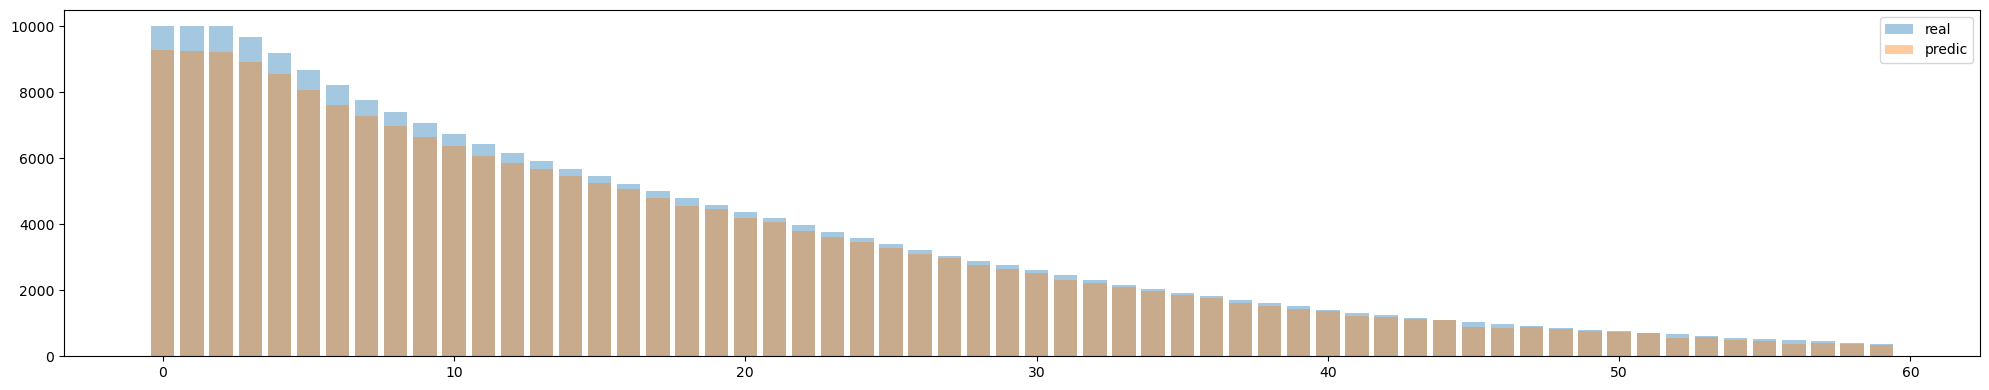

In [15]:

print('trajectory num:', len(real_load))
print('difference per time:', predic_load_per_time - real_load_per_time)
print('difference per road:', predic_load_per_road - real_load_per_road)
print('difference total:', predic_load_total - real_load_total)
print('mae', np.abs(predic_load - real_load).mean())
print('mae per time overall:', np.abs(predic_load_per_time - real_load_per_time).mean())
print('mae per road overall', np.abs(predic_load_per_road - real_load_per_road).mean())

plt.figure(figsize=(20, 4))
plt.bar(range(len(real_load_per_time)), real_load_per_time, alpha=0.4, label='real')
plt.bar(range(len(predic_load_per_time)), predic_load_per_time, alpha=0.4, label='predic')
plt.legend()
plt.tight_layout()
# plt.ylim(0, 100)
plt.show()

# plt.figure(figsize=(20, 4))
# plt.bar(range(len(real_load_per_road)), real_load_per_road, alpha=0.5, label='real')
# plt.bar(range(len(predic_load_per_road)), predic_load_per_road, alpha=0.5, label='predic')
# plt.legend()
# plt.ylim(0, 100)
# plt.show()


### print trajectory

In [16]:
# print the trajectory
from utils import print_trajectory

print('Without correction:')

print(test_trajectory.shape)
# print_trajectory(predic_trajectory, test_trajectory, test_condition)

Without correction:
(10000, 60)


### plot trajectory

# plot the trajectory
from utils import plot_trajs, remove_special_token
from dataset import read_city

_, pos = read_city('boston')

fig_size = 20
plot_num = min(5, test_num)

for i in range(plot_num):
    fig, ax = plt.subplots(1, total_trajectories, figsize=((fig_size+1)*total_trajectories, fig_size))
    for j in range(total_trajectories):
        traj = predic_trajectory[i] # (block_size,)
        traj_ = test_trajectory[i] # (block_size,)
        traj = remove_special_token(traj)
        traj_ = remove_special_token(traj_) # original 1-index, now 0-index

        test_weight_adj = transfer_table_to_matrix(test_adj_table[i])
        G = transfer_graph(test_adj_table[i])
        if total_trajectories == 1:
            plot_trajs(ax, G, pos, test_weight_adj, traj, traj_, ground_truth=False)
        else:
            plot_trajs(ax[j], G, pos, test_weight_adj, traj, traj_, ground_truth=False)
    plt.show()


(117.063531, 36.650371)
0.0 2.2


/tmp/ipykernel_1075528/2133308592.py:38: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, width=figure_size/15, alpha=1, edge_color=edge_colors, ax=ax, arrows=False)


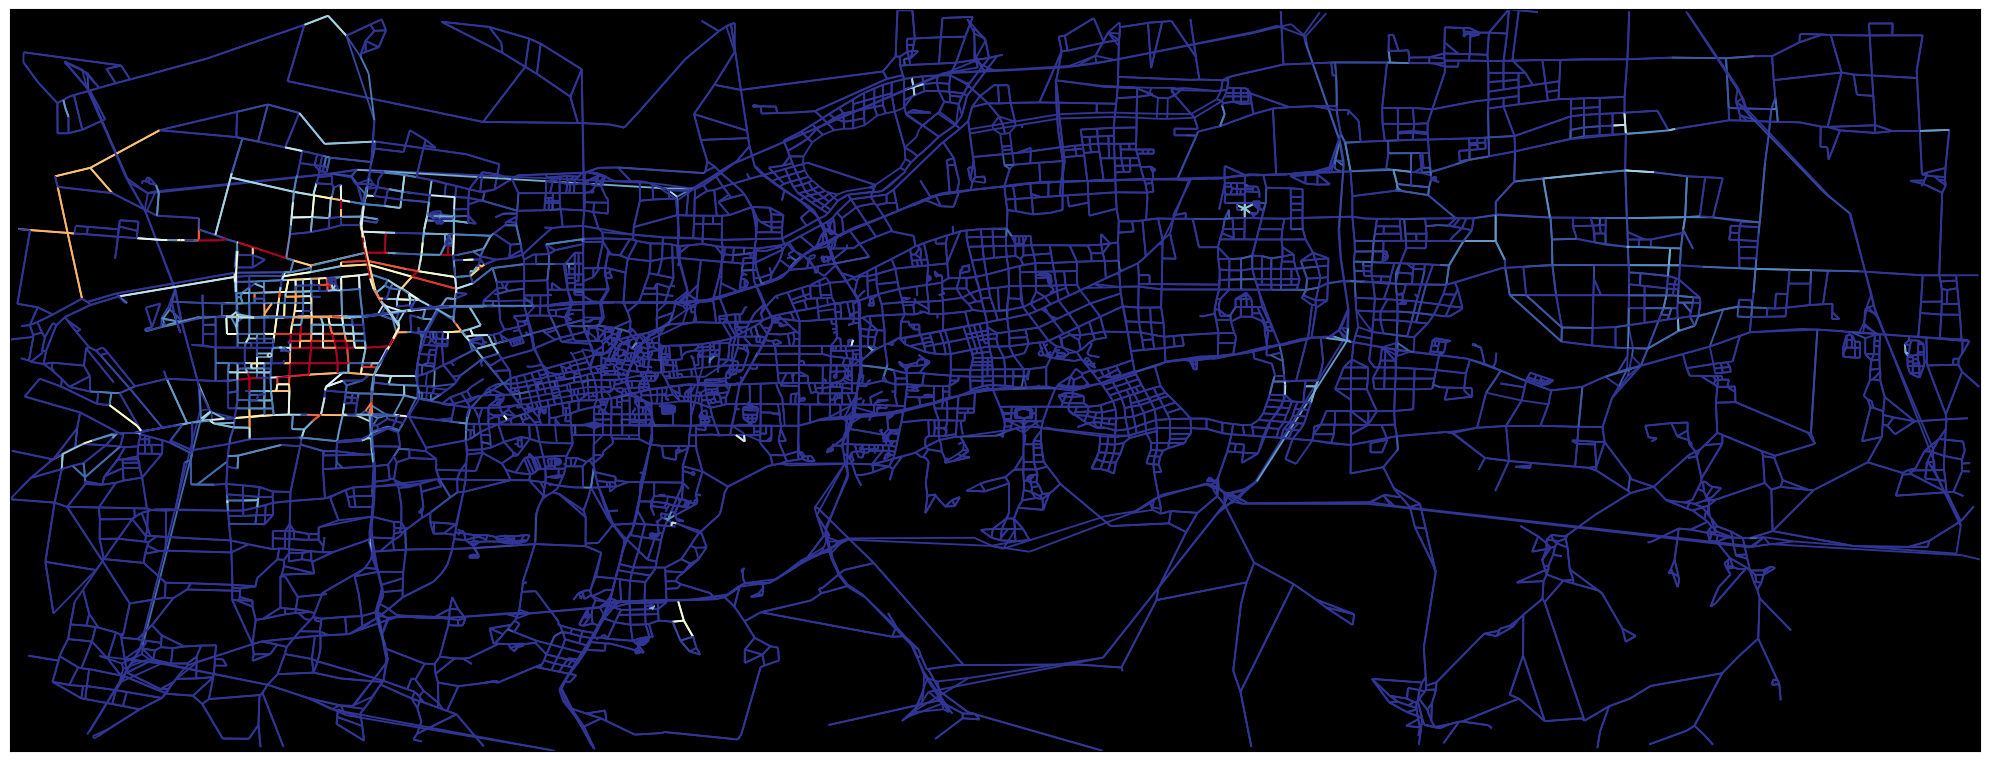

0.0 1.840120588030134


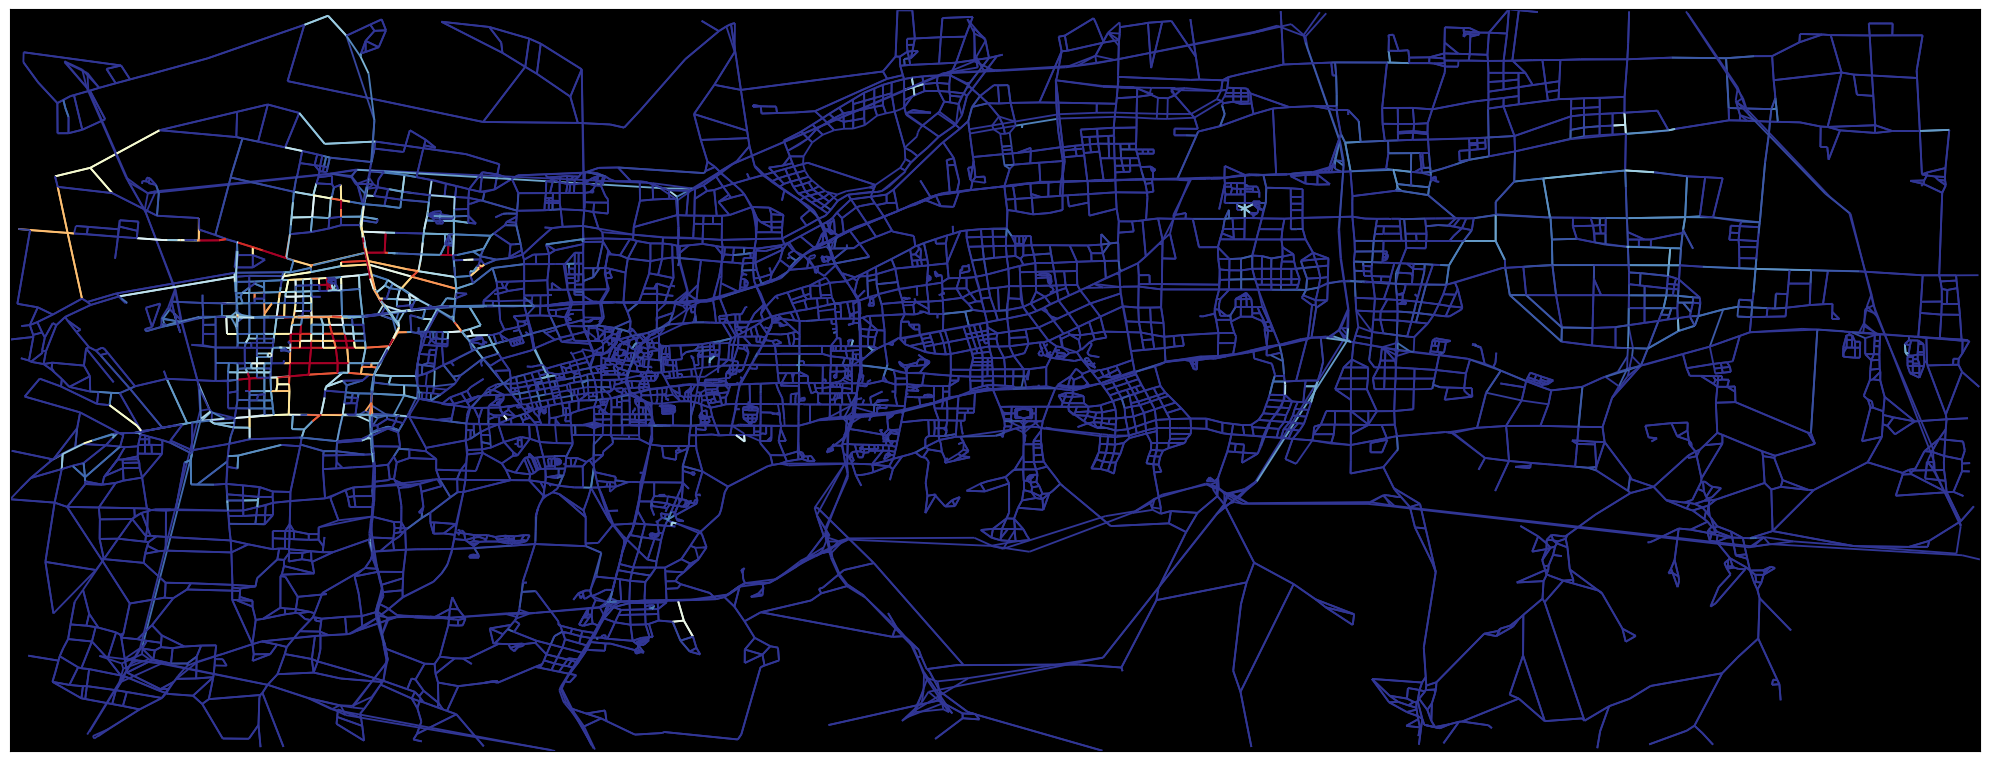

In [29]:
# plot pure graph
# from utils import plot_volume
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2
from utils import calculate_bounds
from dataset import read_city

def plot_volume(G, pos, volume_single, max_volume, figure_size=20, save_path=None):
    # G networkx graph
    # pos position of the nodes, get from  read_city('boston')[1]
    # volume_single: V

    x_min, x_max, y_min, y_max = calculate_bounds(pos)
    fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size*(y_max-y_min)/(x_max-x_min)))
    ax.set_facecolor('black')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(np.arange(x_min, x_max, 1))
    ax.set_yticks(np.arange(y_min, y_max, 1))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
    ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)

    edge_colors = np.array([(volume_single[int(u)-1]+volume_single[int(v)-1])/2 for u, v in G.edges()])
    edge_colors = edge_colors / max_volume
    print(edge_colors.min(), edge_colors.max())
    edge_colors = plt.cm.RdYlBu(1 - edge_colors)
    # edge_colors = plt.cm.rainbow(edge_colors)
    # colors = ["white","blue", "green", "yellow", "red"]
    # cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
    # edge_colors = cmap(edge_colors)

    # nx.draw_networkx_nodes(G, pos, node_size=100, node_color='gray',ax=ax)
    nx.draw_networkx_edges(G, pos, width=figure_size/15, alpha=1, edge_color='black', ax=ax, arrows=False)
    nx.draw_networkx_edges(G, pos, width=figure_size/15, alpha=1, edge_color=edge_colors, ax=ax, arrows=False)

    # ax.legend()
    plt.tight_layout()
    plt.show()
    if save_path != None:
        plt.savefig(save_path)

def make_volume_frames(G, pos, volume_all, max_volume, figure_size=20, save_path = './videos'):
    # G: networkx graph
    # pos: position of the nodes
    # volume_all: (T, V) where T is time and V is volume
    # max_volume: maximum volume for normalization

    # Calculate bounds for the plot
    x_min, x_max, y_min, y_max = calculate_bounds(pos)

    colors = ["white", "blue", "green", "yellow", "red"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)

    for i in range(len(volume_all)):
        volume_single = volume_all[i]
        edge_colors = np.array([(volume_single[int(u)-1] + volume_single[int(v)-1]) / 2 for u, v in G.edges()])
        edge_colors = edge_colors / max_volume
        # edge_colors = cmap(edge_colors)
        edge_colors = plt.cm.RdYlBu(1 - edge_colors)

        # Create a new figure for the current frame
        fig, ax = plt.subplots(figsize=(figure_size, figure_size * (y_max - y_min) / (x_max - x_min)))
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(np.arange(x_min, x_max, 1))
        ax.set_yticks(np.arange(y_min, y_max, 1))
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
        ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5)

        # Draw nodes and edges
        nx.draw_networkx_edges(G, pos, width=figure_size / 15, alpha=1, edge_color='black', ax=ax, arrows=False)
        nx.draw_networkx_edges(G, pos, width=figure_size / 15, alpha=1, edge_color=edge_colors, ax=ax, arrows=False)

        # Convert the figure to an image and write it to the video
        plt.axis('off')  # Hide axes
        plt.draw()
        plt.tight_layout()
        if save_path != None:
            plt.savefig(f'{save_path}/frame_{i}.png')

        plt.close(fig)  # Close the figure

def make_video_from_frames(frames_dir, video_path):
    # Create a VideoCapture object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    frame = cv2.imread(f'{frames_dir}/frame_{0}.png')
    frame_height, frame_width, _ = frame.shape
    out = cv2.VideoWriter(video_path, fourcc, 2, (frame_width, frame_height))

    # Iterate over all the frames
    for i in range(len(os.listdir(frames_dir))):
        frame = cv2.imread(f'{frames_dir}/frame_{i}.png')
        out.write(frame)

    # Release the VideoCapture object
    out.release()

# _, pos = read_city('boston')
_, pos = read_city('jinan',path='./data_city/')
for i in pos:
    pos[i] = pos[i][:-1]
print(pos[0])

fig_size = 20

adj_table = test_adj_table[0] #[v,e,2]
G = transfer_graph(adj_table) # 0-indexed

volume = real_load[20]
max_volume = np.max(real_load)/10
plot_volume(G, pos, volume, max_volume, fig_size)
volume = predic_load[20]
plot_volume(G, pos, volume, max_volume, fig_size)
# make_volume_frames(G, pos, real_load, max_volume, fig_size, './videos/jinan/real/frames')
# make_video_from_frames('./videos/jinan/real/frames','./videos/jinan/real/video.mp4')